In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
import time
from moviepy.editor import VideoFileClip


In [2]:
def read_file(full_filename):
    filename, file_extension = os.path.splitext(full_filename)
    image = mpimg.imread(full_filename)
    if (file_extension != '.png'):
        image = image.astype(np.float32) / 255
    return image
    

# Histogram of Oriented Gradients (HOG)

In [3]:

def get_files_from_dir(dir):    
    filenames = []
    list = os.listdir(dir)
    for subdir in list:
        if (dir != '.DS_Store'):
            images_dir = dir+'/'+subdir
            dir_filenames = glob.glob(images_dir+'/*.png')
            filenames.extend(dir_filenames)
    return filenames

cars = get_files_from_dir('dataset/vehicles')
notcars = get_files_from_dir('dataset/non-vehicles')


In [4]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = read_file(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('data_look returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

data_look returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=feature_vec)
        return features


In [6]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [7]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [8]:
spatial_size = (32, 32)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2

def single_image_features(image):
    global spatial_size
    global hist_bins
    global hist_range
    global orient
    global pix_per_cell
    global cell_per_block
    # apply color conversion if other than 'RGB'
    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
# Apply bin_spatial() to get spatial color features
    
    bin = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() to get color histogram features
    hist = color_hist(feature_image, hist_bins)
    hog_features = []
    for channel in range(feature_image.shape[2]):
        hog_features.append(get_hog_features(feature_image[:,:,channel], 
                            orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True))
    hog_features = np.ravel(hog_features)        

    # Append the new feature vector to the features list
    return np.concatenate((bin, hist, hog_features))
#     return hog_features

def extract_features(imgs):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img_name in imgs:
        # Read in each one by one
        image = read_file(img_name)
        image_features = single_image_features(image)
        features.append(image_features)
    # Return list of feature vectors

    return features

# Training a classifier

In [9]:
t=time.time()

car_features = extract_features(cars)
notcar_features = extract_features(notcars)

print("extracting features took {} seconds".format(time.time()-t))

t=time.time()
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

extracting features took 74.40130591392517 seconds
Feature vector length: 8460
44.44 Seconds to train SVC...
Test Accuracy of SVC =  0.9927
My SVC predicts:  [ 1.  1.  0.  0.  0.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  0.  1.  0.  0.]
0.00459 Seconds to predict 10 labels with SVC


# Sliding window search

In [10]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 1), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    window_list = []
    # Loop through finding x and y window positions
    for y in range(ny_windows):
        for x in range(nx_windows):
            x_start = x_start_stop[0] + x * nx_pix_per_step
            y_start = y_start_stop[0] + y * ny_pix_per_step
            window_list.append(((x_start, y_start), (x_start + xy_window[0], y_start + xy_window[1])))
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    # Return the list of windows
    return window_list



In [11]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows):
    global X_scaler
    global svc
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_image_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = svc.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


In [12]:

def detect_vehicles(image, draw_image, xy_window, xy_overlap, color=(0, 0, 255)):
    windows = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[350, 720], 
                        xy_window=xy_window, xy_overlap=xy_overlap)
    hot_windows = search_windows(image, windows)
    print("found windows count ", len(hot_windows))
    draw_image = draw_boxes(draw_image, hot_windows, color=color, thick=6)                    
    return draw_image, len(windows)


In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [14]:
def apply_threshold(heatmap, threshold, can_override):
    if can_override:
        threshold_heatmap = heatmap
    else:
        threshold_heatmap = np.copy(heatmap)
    # Zero out pixels below the threshold
    threshold_heatmap[threshold_heatmap <= threshold] = 0
    # Return thresholded map
    return threshold_heatmap



In [15]:
def find_cars(img, debug, ystart, ystop, scale):
    global svc
    global orient
    global pix_per_cel
    global cell_per_block
    
    start = time.time()
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
#             print (xpos, ypos, nblocks_per_window)
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#             test_features = hog_features.reshape(1, -1)
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
#             test_prediction = svc.predict(test_features)
            confidence = svc.decision_function(test_features)
            if confidence > 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                 if debug:
#                     confidence = svc.decision_function(test_features)
#                     print("confidence score {}".format(confidence))
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    end = time.time()
#     print('find_cars took {} ms'.format((end - start) * 1000))
    return bboxes


In [16]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



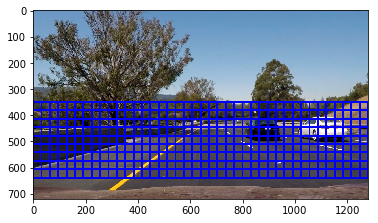

pix_per_cell 8
cell_per_block
scale 1.3 took 568.5939788818359 ms
scale 1.6 took 321.85912132263184 ms
scale 1.9000000000000001 took 288.5870933532715 ms
scale 2.2 took 137.9079818725586 ms


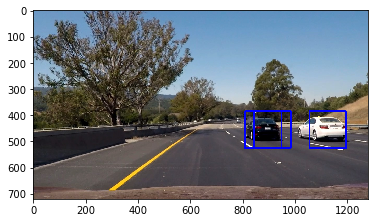

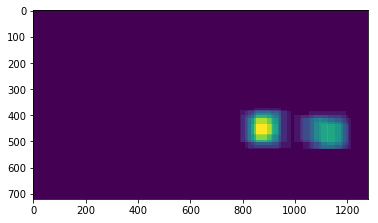

2 cars found


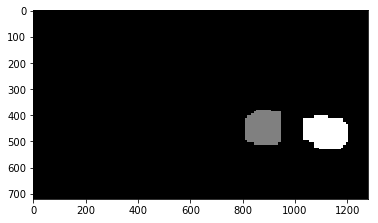

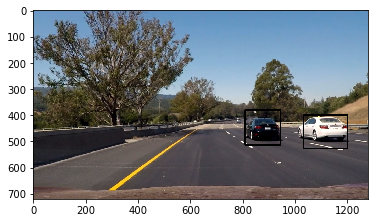

In [22]:
ystart = 350
ystop = 656

image = read_file('test_images/test6.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[ystart, ystop], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
            
# slide windows
window_img = draw_boxes(image, windows, color=(0, 0, 1), thick=6)                    
plt.imshow(window_img)
plt.show()
# plt.savefig('output_images/slide_windows.jpg')

draw_image = image.copy()
heat = np.zeros_like(image[:,:,0]).astype(np.float)

print('pix_per_cell {}'.format(pix_per_cell))
print('cell_per_block'.format(cell_per_block))
scale = 1
while scale < 2:
    time1 = time.time()
    scale += 0.3
    box_list = find_cars(image, True, ystart, ystop, scale)
    heat = add_heat(heat,box_list)
    time2 = time.time()
    print("scale {} took {} ms".format(scale, (time2-time1) * 1000))



# found car in these windows
draw_image = draw_boxes(image, box_list, color=(0, 0, 1), thick=6)
plt.imshow(draw_image)
plt.show()
# plt.savefig('output_images/hot_windows.jpg')

# heat map
plt.imshow(heat)
plt.show()
# plt.savefig('output_images/heatmap.jpg')

#threshold heatmap
heatmap = apply_threshold(heat, 3, True)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.show()
# plt.savefig('output_images/heatmap_threshold.jpg')

#result car detections
detected_cars = draw_labeled_bboxes(image, labels)
plt.imshow(detected_cars)
plt.show()
# plt.savefig('output_images/detected_cars.jpg')


# Using scale for efficiency

In [23]:

def get_heatmap_for_image(image, debug = False):
    orig_image = np.copy(image)
    if debug == False: #debug here means it was from jpg file. otherwise it is from video feed
        image = image.astype(np.float32) / 255

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    all_box_list = []
    box_list_count = 0
    time1 = time.time()
    scales = [1.3, 1.6, 2]
    for scale in scales:
        box_list = find_cars(image, debug, ystart, ystop, scale)
        heat = add_heat(heat,box_list)
        box_list_count += len(box_list)
        if debug:
            all_box_list.append(box_list)

    heatmap = apply_threshold(heat, 1, True)
    time2 = time.time()
    if debug:
        print('process frame took {} ms. found {} boxes'.format((time2-time1) * 1000, box_list_count))
                
    if debug:
        return heatmap, all_box_list, heat
    else:
        return heatmap


process frame took 981.931209564209 ms. found 25 boxes
process frame took 1028.0790328979492 ms. found 0 boxes
process frame took 980.1449775695801 ms. found 1 boxes
process frame took 992.840051651001 ms. found 21 boxes
process frame took 987.6930713653564 ms. found 17 boxes
process frame took 974.1430282592773 ms. found 24 boxes
process frame took 974.3959903717041 ms. found 22 boxes


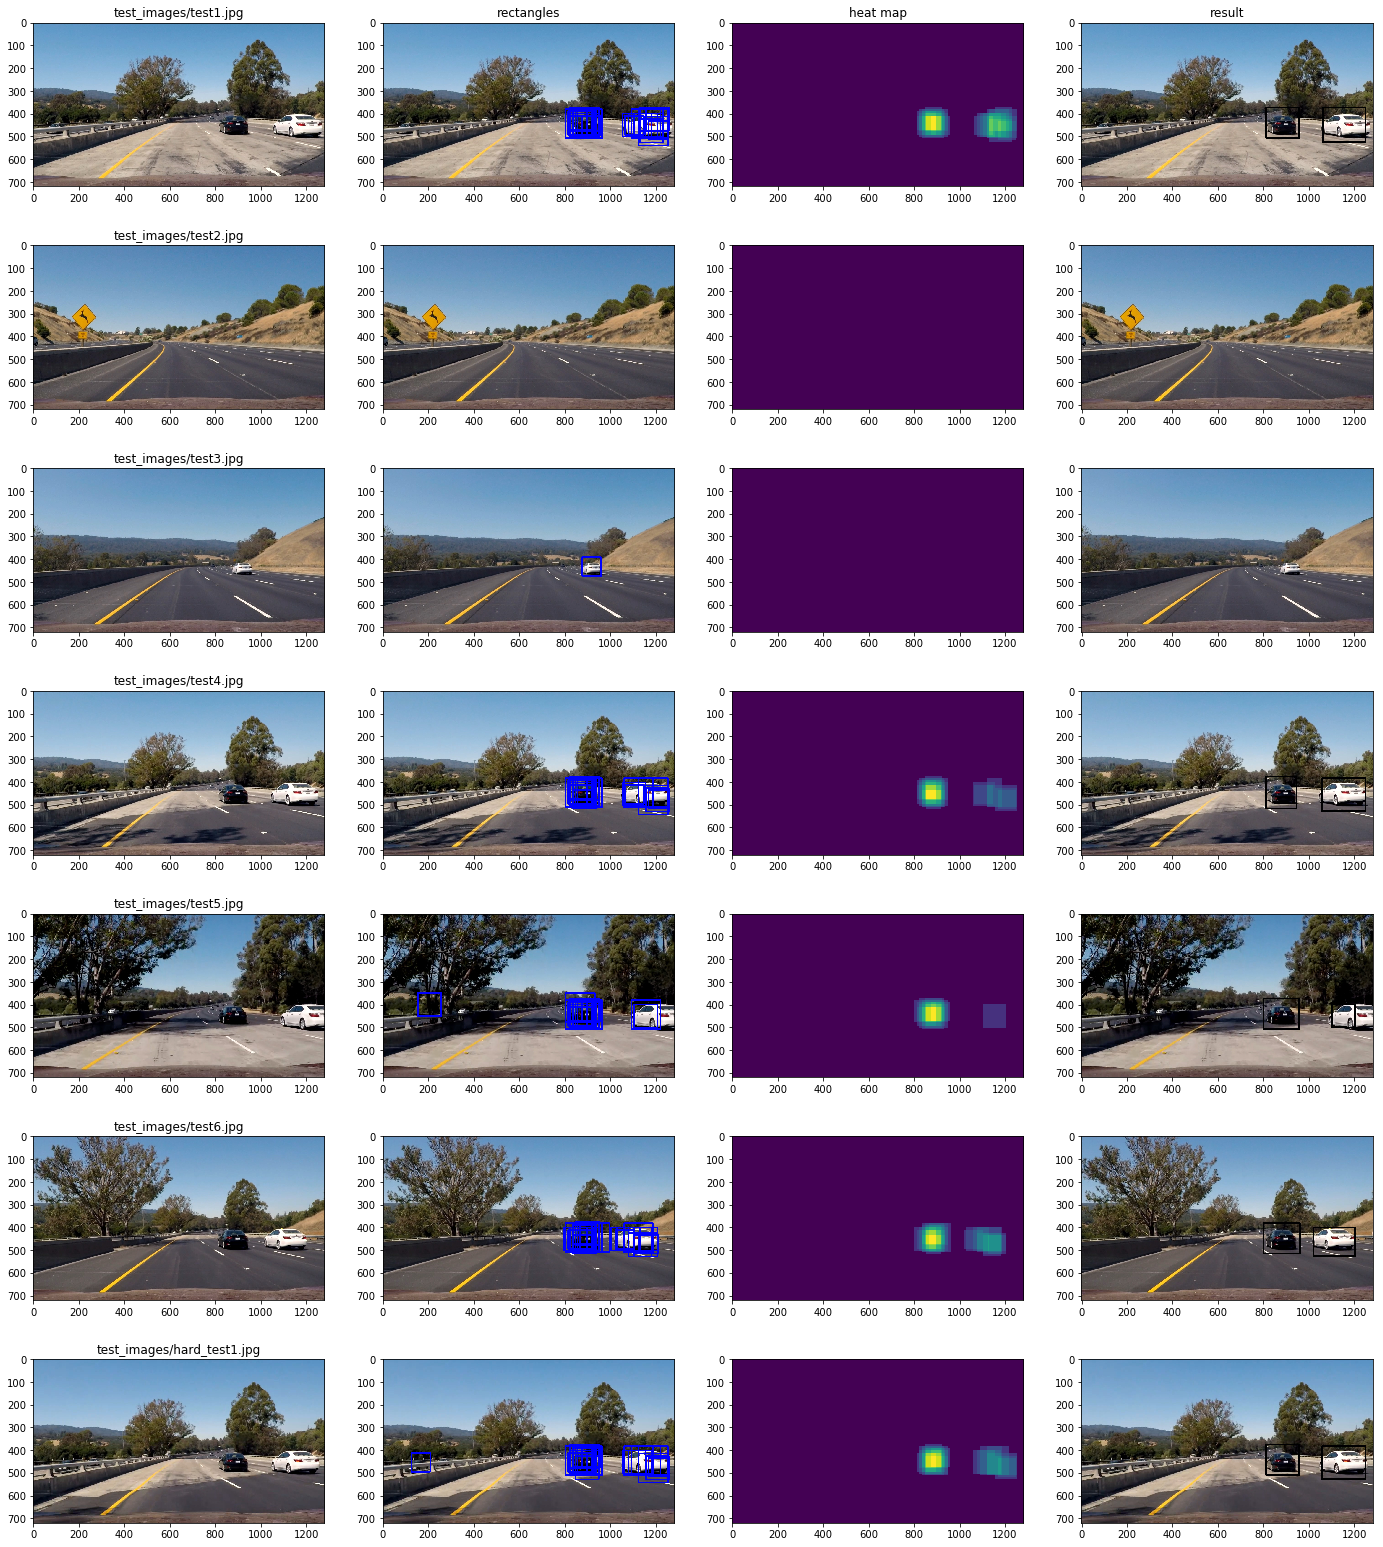

In [24]:
image_names = [
    'test_images/test1.jpg',
    'test_images/test2.jpg',
    'test_images/test3.jpg',
    'test_images/test4.jpg',
    'test_images/test5.jpg',
    'test_images/test6.jpg',
    'test_images/hard_test1.jpg'
              ]

f, axarr = plt.subplots(len(image_names), 4, figsize=(24, len(image_names) * 4))
axarr[0,0].set_title('original')
axarr[0,1].set_title('rectangles')
axarr[0,2].set_title('heat map')
axarr[0,3].set_title('result')
for idx, image_name in enumerate(image_names):
#     print('process image_name')
    axarr[idx, 0].set_title(image_name)
    image = read_file(image_name)
    axarr[idx, 0].imshow(image)
    heatmap, box_list, img2 = get_heatmap_for_image(image, True)
#     image = image.astype(np.float32) / 255
    flatten = [item for sublist in box_list for item in sublist]
    boxes_image = draw_boxes(image, flatten, color=(0, 0, 1), thick=6)
    labels = label(heatmap)
    result = draw_labeled_bboxes(image, labels)
    axarr[idx, 1].imshow(boxes_image)
    axarr[idx, 2].imshow(heatmap)
    axarr[idx, 3].imshow(result)
plt.show()
# plt.savefig('output_images/scales.jpg')


In [25]:
def reduce_heatmap_count(heatmap):
    return (heatmap > 0).astype(np.int)

def combine_heatmaps(heatmaps):
    combined_heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    for heatmap in heatmaps:
        combined_heatmap = combined_heatmap + heatmap
    return combined_heatmap

def process_image(image):
    global latest_heatmaps
    heatmap = get_heatmap_for_image(image)
    flat_heatmap = reduce_heatmap_count(heatmap)
    latest_heatmaps.append(flat_heatmap)
    if len(latest_heatmaps) > 6:
        latest_heatmaps = latest_heatmaps[-6:]
    combined_heatmap = combine_heatmaps(latest_heatmaps)
    threshold = (int) (len(latest_heatmaps) * 0.66)
#     print(len(latest_labels), threshold)
    current_heatmap = apply_threshold(combined_heatmap, threshold, False)
    labels = label(current_heatmap)
    result = np.copy(image)
    result = draw_labeled_bboxes(result, labels)
    return result
    

In [26]:
import scipy.misc
image_count = 0

latest_heatmaps = []

video_filename_prefix = "project_video"
# video_filename_prefix = "test_video"
clip1 = VideoFileClip("{}.mp4".format(video_filename_prefix))
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile("{}_output.mp4".format(video_filename_prefix), audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [22:36<00:01,  1.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 21min 45s, sys: 1min 1s, total: 22min 47s
Wall time: 22min 37s


In [ ]:
test = np.array([[10, 0, 4], [1, 1, 0]])
print(test)
# result = [x>0 for x in test]
result = (test > 0).astype(np.int)
# result = result.astype(np.int)
print(result)